In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt

In [2]:
if torch.cuda.is_available():
    device=torch.device(type='cuda',index=0)
else:
    device=torch.device(type='cpu',index=0)

In [4]:
trainDS=datasets.MNIST(
    root="/kaggle/temp/",
    train=True,
    download=True,
    transform=ToTensor()
)

testDS=datasets.MNIST(
    root="/kaggle/temp/",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size=64

trainDL=DataLoader(dataset=trainDS, batch_size=batch_size, shuffle=True)
testDL=DataLoader(dataset=testDS, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [04:59<00:00, 33043.86it/s]


Extracting /kaggle/temp/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 479149.47it/s]

Extracting /kaggle/temp/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw



Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4410884.13it/s]


Extracting /kaggle/temp/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/temp/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 3547584.50it/s]

Extracting /kaggle/temp/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/temp/MNIST/raw



In [8]:
class Encoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.l1=nn.Linear(in_features=784,out_features=512)
       
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
       
        return out1
    
class Decoder1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.sig=nn.Sigmoid()
        self.l1=nn.Linear(in_features=512,out_features=784)
        
    
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
       
        return out1

class Encoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.l1=nn.Linear(in_features=512,out_features=256)
        self.l2=nn.Linear(in_features=256,out_features=100)
            
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        net2=self.l2(out1)
        out2=self.lkrelu(net2)
        return out2
    
class Decoder2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lkrelu=nn.LeakyReLU(0.1)
        self.l1=nn.Linear(in_features=100,out_features=256)
        self.l2=nn.Linear(in_features=256,out_features=512)
            
    def forward(self,x):
        net1=self.l1(x)
        out1=self.lkrelu(net1)
        net2=self.l2(out1)
        out2=self.lkrelu(net2)
        return out2


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.out=nn.Linear(in_features=100,out_features=10)
    
    def forward(self,x):
        out=self.out(x)
        return out

In [9]:
lossmse_fn=nn.MSELoss()
lossentropy_fn=nn.CrossEntropyLoss()
lr=0.001

e1=Encoder1().to(device)
d1=Decoder1().to(device)
e2=Encoder2().to(device)
d2=Decoder2().to(device)
clf=Classifier().to(device)

opte1=Adam(params=e1.parameters(),lr=lr)
optd1=Adam(params=d1.parameters(),lr=lr)
opte2=Adam(params=e2.parameters(),lr=lr)
optd2=Adam(params=d2.parameters(),lr=lr)
optclf=Adam(params=clf.parameters(),lr=lr)

In [10]:
def trainAE1():    
    track_loss=0
    
    e1.train()
    d1.train()
    
    for i,(x,_) in enumerate(trainDL):
        x=torch.reshape(x,shape=(-1,784))
        x=x.to(device)

        latent=e1(x)
        pred=d1(latent)
            
        loss=lossmse_fn(pred,x)
        
        track_loss+=loss.item()
          
        loss.backward()
        
        opte1.step()
        optd1.step()
        
        opte1.zero_grad()
        optd1.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
            
    return round(running_loss,4)

def trainAE2():    
    track_loss=0
    
    e2.train()
    d2.train()
    
    for i,(x,_) in enumerate(trainDL):
        x=torch.reshape(x,shape=(-1,784))
        x=x.to(device)

        latente1=e1(x)
        latente2=e2(latente1.detach())
        pred=d2(latente2)
            
        loss=lossmse_fn(pred,latente1.detach()) 
        
        track_loss+=loss.item()
        
        loss.backward()
        
        opte2.step()
        optd2.step()
        opte2.zero_grad()
        optd2.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
    
    return round(running_loss,4)

def trainClassifier():  
    track_loss=0
    num_correct=0
    
    clf.train()
    
    for i,(x,y) in enumerate(trainDL):
        x=torch.reshape(x,shape=(-1,784))
        x=x.to(device)
        y=y.to(device)

        latente1=e1(x)
        latente2=e2(latente1)
        pred=clf(latente2.detach())
        
        num_correct+=(torch.argmax(pred,dim=1)==y).type(torch.float).sum().item()
            
        loss=lossentropy_fn(pred,y)
        
        track_loss+=loss.item()
        
        loss.backward()
        
        optclf.step()
        optclf.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
        running_acc=(num_correct/((i*batch_size+x.shape[0])))*100
    
    return round(running_loss,4), round(running_acc,2)
        
def trainFinetune():
    track_loss=0
    num_correct=0
    
    e1.train()
    e2.train()
    clf.train()
    
    for i,(x,y) in enumerate(trainDL):
        x=torch.reshape(x,shape=(-1,784))
        x=x.to(device)
        y=y.to(device)

        latente1=e1(x)
        latente2=e2(latente1)
        pred=clf(latente2)
        
        num_correct+=(torch.argmax(pred,dim=1)==y).type(torch.float).sum().item()
            
        loss=lossentropy_fn(pred,y)
        
        track_loss+=loss.item()
        
        loss.backward()
        
        opte1.step()
        opte2.step()
        optclf.step()
        
        opte1.zero_grad()
        opte2.zero_grad()
        optclf.zero_grad()
        
        running_loss=track_loss/(i+(x.shape[0]/batch_size))
        running_acc=(num_correct/((i*batch_size+x.shape[0])))*100
    
    return round(running_loss,4),round(running_acc,2)

In [29]:
def evalAE1():
    track_loss=0
    
    e1.eval()
    d1.eval()
    
    with torch.no_grad():
        for i,(x,_) in enumerate(testDL):
            x=torch.reshape(x,shape=(-1,784))
            x=x.to(device)

            latent=e1(x)
            pred=d1(latent)

            loss=lossmse_fn(pred,x)
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
    
    return round(running_loss,4),x,pred

def evalAE2():
    track_loss=0
    
    e1.eval()
    e2.eval()
    d2.eval()
    
    with torch.no_grad():
        for i,(x,_) in enumerate(testDL):
            x=torch.reshape(x,shape=(-1,784))
            x=x.to(device)

            latente1=e1(x)
            latente2=e2(latente1)
            pred=d2(latente2)

            loss=lossmse_fn(pred,latente1)
            
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
            
    e1.eval()
    d1.eval()
    pred = d1(pred)
    
    return round(running_loss,4), x.detach(), pred.detach()
            
        
def evalClassifier():
    track_loss=0
    num_correct=0
    
    clf.eval()
    e1.eval()
    e2.eval()
    d2.eval()
    d1.eval()
    
    with torch.no_grad():
        for i,(x,y) in enumerate(testDL):
            x=torch.reshape(x,shape=(-1,784))
            x=x.to(device)
            y=y.to(device)

            latente1=e1(x)
            latente2=e2(latente1)
            pred=clf(latente2)
            
            num_correct+=(torch.argmax(pred,dim=1)==y).type(torch.float).sum().item()
            running_acc=(num_correct/((i*batch_size+x.shape[0])))*100
            
            loss=lossentropy_fn(pred,y)
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
            
    pred = d1(d2(latente2)).detach()
    return round(running_loss,4), x.detach(), pred
        
def evalFinetune_ed():
    track_loss=0
    num_correct=0
    
    clf.eval()
    e1.eval()
    e2.eval()
    d2.eval()
    d1.eval()
    
    with torch.no_grad():
        for i,(x,y) in enumerate(testDL):
            x=torch.reshape(x,shape=(-1,784))
            x=x.to(device)
            y=y.to(device)

            latente1=e1(x)
            latente2=e2(latente1)
            pred=clf(latente2)
            
            num_correct+=(torch.argmax(pred,dim=1)==y).type(torch.float).sum().item()
            running_acc=(num_correct/((i*batch_size+x.shape[0])))*100
            
            loss=lossentropy_fn(pred,y)
            track_loss+=loss.item()
            
            running_loss=track_loss/(i+(x.shape[0]/batch_size))
            
    
    pred = d1(d2(latente2)).detach()
    return round(running_loss,4), round(running_acc,2), x.detach() ,pred

================================================== AutoEncoder 1 ==================================================
Epoch=1, Train Loss=0.0059, Eval Loss=0.0016
Epoch=2, Train Loss=0.0011, Eval Loss=0.0008
Epoch=3, Train Loss=0.0006, Eval Loss=0.0005
Epoch=4, Train Loss=0.0004, Eval Loss=0.0004
Epoch=5, Train Loss=0.0004, Eval Loss=0.0004
Epoch=6, Train Loss=0.0003, Eval Loss=0.0003
Epoch=7, Train Loss=0.0003, Eval Loss=0.0003
Epoch=8, Train Loss=0.0003, Eval Loss=0.0003
Epoch=9, Train Loss=0.0003, Eval Loss=0.0003
Epoch=10, Train Loss=0.0003, Eval Loss=0.0002
Epoch=11, Train Loss=0.0003, Eval Loss=0.0003
Epoch=12, Train Loss=0.0002, Eval Loss=0.0003
Epoch=13, Train Loss=0.0003, Eval Loss=0.0002
Epoch=14, Train Loss=0.0003, Eval Loss=0.0004
Epoch=15, Train Loss=0.0002, Eval Loss=0.0003
Epoch=16, Train Loss=0.0002, Eval Loss=0.0003
Epoch=17, Train Loss=0.0002, Eval Loss=0.0003
Epoch=18, Train Loss=0.0002, Eval Loss=0.0003
Epoch=19, Train Loss=0.0002, Eval Loss=0.0004
Epoch=20, Train Los

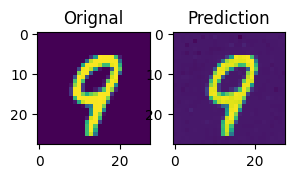

In [12]:
n_epochs=20

print("="*50,"AutoEncoder 1","="*50)

for i in range(n_epochs):
    train_loss=trainAE1()
    eval_loss,x,pred=evalAE1()
    print("Epoch=", i+1,", Train Loss=",train_loss,", Eval Loss=",eval_loss,sep="")
    
plt.figure(figsize=(3.2,2.4))

r=torch.randint(low=0,high=pred.shape[0],size=(1,)).item()

plt.subplot(1,2,1)
plt.title("Orignal")
plt.imshow(torch.reshape(x[r],shape=(28,28)).cpu())

plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(torch.reshape(pred[r],shape=(28,28)).cpu())
plt.show()

================================================== AutoEncoder 2 ==================================================
Epoch=1, Train Loss=0.0072, Eval Loss=0.0071


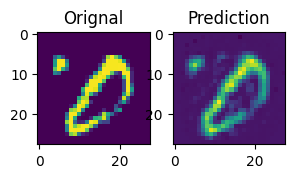

In [20]:
n_epochs = 1 # The model (AE2) is already trained on 20+ epochs. The number is set to 1 to fix an error. Keep this 20

print("="*50,"AutoEncoder 2","="*50)

for i in range(n_epochs):
    train_loss=trainAE2()
    eval_loss,x,pred=evalAE2()
    print("Epoch=", i+1,", Train Loss=",train_loss,", Eval Loss=",eval_loss,sep="")
    
plt.figure(figsize=(3.2,2.4))

r=torch.randint(low=0,high=pred.shape[0],size=(1,)).item()

plt.subplot(1,2,1)
plt.title("Orignal")
plt.imshow(torch.reshape(x[r],shape=(28,28)).cpu())

plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(torch.reshape(pred[r],shape=(28,28)).cpu())
plt.show()

================================================== Classifier ==================================================
Epoch=1, Train Loss=(0.6801, 86.12), Eval Loss=0.5956
Epoch=2, Train Loss=(0.5714, 87.18), Eval Loss=0.5163
Epoch=3, Train Loss=(0.5086, 87.84), Eval Loss=0.4667
Epoch=4, Train Loss=(0.4679, 88.33), Eval Loss=0.4324
Epoch=5, Train Loss=(0.4394, 88.77), Eval Loss=0.4083
Epoch=6, Train Loss=(0.4187, 89.08), Eval Loss=0.3913
Epoch=7, Train Loss=(0.4028, 89.32), Eval Loss=0.3783
Epoch=8, Train Loss=(0.3903, 89.52), Eval Loss=0.3674
Epoch=9, Train Loss=(0.3799, 89.66), Eval Loss=0.3622
Epoch=10, Train Loss=(0.3717, 89.8), Eval Loss=0.3509
Epoch=11, Train Loss=(0.3649, 89.9), Eval Loss=0.3459
Epoch=12, Train Loss=(0.3586, 90.01), Eval Loss=0.3395
Epoch=13, Train Loss=(0.3531, 90.18), Eval Loss=0.3362
Epoch=14, Train Loss=(0.349, 90.33), Eval Loss=0.3305
Epoch=15, Train Loss=(0.345, 90.38), Eval Loss=0.3284
Epoch=16, Train Loss=(0.341, 90.42), Eval Loss=0.3248
Epoch=17, Train Loss=

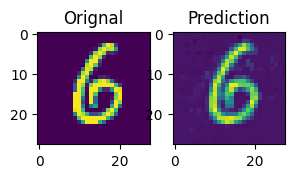

In [25]:
n_epochs = 20

print("="*50,"Classifier","="*50)

for i in range(n_epochs):
    train_loss=trainClassifier()
    eval_loss,x,pred=evalClassifier()
    print("Epoch=", i+1,", Train Loss=",train_loss,", Eval Loss=",eval_loss,sep="")
    
plt.figure(figsize=(3.2,2.4))

r=torch.randint(low=0,high=pred.shape[0],size=(1,)).item()

plt.subplot(1,2,1)
plt.title("Orignal")
plt.imshow(torch.reshape(x[r],shape=(28,28)).cpu())

plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(torch.reshape(pred[r],shape=(28,28)).cpu())
plt.show()

================================================== Fine Tuning ==================================================
Epoch=1, Train Loss=(0.05, 98.41), Eval Loss=0.092, Eval Accuracy=97.73
Epoch=2, Train Loss=(0.0436, 98.61), Eval Loss=0.0978, Eval Accuracy=97.33
Epoch=3, Train Loss=(0.0378, 98.79), Eval Loss=0.0952, Eval Accuracy=97.76
Epoch=4, Train Loss=(0.0354, 98.92), Eval Loss=0.1294, Eval Accuracy=97.22
Epoch=5, Train Loss=(0.0319, 99.03), Eval Loss=0.1248, Eval Accuracy=97.4
Epoch=6, Train Loss=(0.032, 99.0), Eval Loss=0.1131, Eval Accuracy=97.68
Epoch=7, Train Loss=(0.032, 99.04), Eval Loss=0.1196, Eval Accuracy=97.71
Epoch=8, Train Loss=(0.0273, 99.16), Eval Loss=0.1326, Eval Accuracy=97.33
Epoch=9, Train Loss=(0.0259, 99.2), Eval Loss=0.1478, Eval Accuracy=97.51
Epoch=10, Train Loss=(0.0234, 99.27), Eval Loss=0.1157, Eval Accuracy=98.04
Epoch=11, Train Loss=(0.028, 99.22), Eval Loss=0.1473, Eval Accuracy=97.47
Epoch=12, Train Loss=(0.0249, 99.28), Eval Loss=0.1493, Eval Accurac

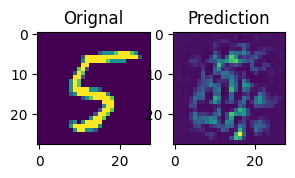

In [31]:
n_epochs = 20

print("="*50,"Fine Tuning","="*50)

for i in range(n_epochs):
    train_loss=trainFinetune()
    eval_loss,eval_acc,x,pred=evalFinetune_ed()
    print("Epoch=", i+1,", Train Loss=",train_loss,", Eval Loss=",eval_loss,", Eval Accuracy=",eval_acc,sep="")
    
plt.figure(figsize=(3.2,2.4))

r=torch.randint(low=0,high=pred.shape[0],size=(1,)).item()

plt.subplot(1,2,1)
plt.title("Orignal")
plt.imshow(torch.reshape(x[r],shape=(28,28)).cpu())

plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(torch.reshape(pred[r],shape=(28,28)).cpu())
plt.show()

**NOTE:**

Output Images in last three is not much helpful to see, because decoders (d1 in AE2 & d1-d2 in last two aren't being trained)

This is added just to see what is happening, since viewing latent space repr, isn't much helpful